<a href="https://colab.research.google.com/github/RakeshReddyKondeti/Robotics_UniversityofLuebeck/blob/master/ComputerVision_Exercise_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision SS 2021
## Exercise Sheet 4: Greedy snake
### Erhardt Barth / Philipp Gruening / Christoph Linse / Manuel Laufer
Universität zu Lübeck, Institut für Neuro- und Bioinformatik

In case of questions, contact us via email: *{barth, gruening, linse, laufer} @inb.uni-luebeck.de*

## Note: Please insert the names of all participating students:

1. Rakesh Reddy Kondeti
2. Christopher Schmale
3. Tim-Henrik Traving
4. 
5. 


In [ ]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-luebeck/cs4250.git'
    os.chdir('cs4250')

fatal: destination path 'cs4250' already exists and is not an empty directory.


In [ ]:
import numpy as np
from numpy.linalg import norm
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  

In this exercise, a program framework is given. Add the missing parts for the implementation of a greedy 
snake at the marked sections in the code.

* Use the gradient magnitude as image term.
* Calculate the three energy terms $E_{cont}$, $E_{curv}$, and $E_{imag}$.
* Normalize the energy terms over the neighborhood to the intervall $[0,1]$.
* Estimate the point in the neighborhood, that has minimum energy.


**Hint:** Use the following equations for the implementation of the energy terms:\\
\begin{eqnarray}
E_{cont} & = & (0.5\cdot(\|p_i-p_{i-1}\|-\|p_i-p_{i+1}\|))^2 \\
E_{curv} & = & \|p_{i-1}-2 p_i+p_{i+1}\|^2 \\
E_{imag} & = & -\|\nabla I(x,y)\|
\end{eqnarray}

Comment on the difference between using $E_{cont}$ described above and the term $(\bar d-\|p_i-p_{i-1}\|)^2$ given in the lecture.


In [ ]:
def snake(img, contour, **kwargs):
    # parameter initialization
    k = contour.shape[1]
    alpha = kwargs['alpha'] * np.ones(k)
    beta = kwargs['beta'] * np.ones(k)
    gamma = kwargs['gamma'] * np.ones(k)

    # TODO: compute gradient image
    gradient_x, gradient_y = gradient(img)
    norm_image_gradient = cv2.magnitude(gradient_x, gradient_y)

    k_updated = k
    iterations = 0
    # iterate until snake stops changing
    while k_updated > k * kwargs['contour_fraction']:
        iterations = iterations + 1
        k_updated = 0
        
        # update all contour points
        for i in range(k):
            p, updated = greedy_minimization(
                norm_image_gradient, contour, i, alpha, beta, gamma, kwargs['neighborhood_size'])
            if p is not None:
                contour[:, i] = p
            # eliminate corners if required
            if iterations > kwargs['begin_corner_elim']:
                beta = corner_elimination(contour, beta, kwargs['K_threshold'])
            
            # keep track of number of updated points
            if updated:
                #print("True")
                k_updated = k_updated + 1
        
        # display current state of snake
        print('num_updates: {}'.format(k_updated))
        plt.imshow(norm_image_gradient)
        plt.plot(contour[1, :], contour[0, :], 'r.-')
        plt.show()

In [ ]:
def greedy_minimization(norm_image_gradient, contour, i, alpha, beta, gamma, neighborhood_size):
    m, n = norm_image_gradient.shape
    k = contour.shape[1]
    w = (kwargs['neighborhood_size'] - 1.) // 2.
    d = average_distance(contour)
    updated = False

    # get previous, current, and next point in snake
    p_iminus1 = contour[:, wrap_index(i-1, k)]
    p_i = contour[:, i]
    p_iplus1 = contour[:, wrap_index(i+1, k)]

    # compute individual terms of energy functional
    p_list = []

    E_cont = []
    E_curv = []
    E_imag = []

    # For all points in a local neighborhood, compute the energy terms
    for p_i_x in np.arange(max(0, p_i[0] - w), min(m-1, p_i[0]+w)+1):
        for p_i_y in np.arange(max(0, p_i[1]-w), min(n-1, p_i[1]+w)+1):
          # TODO: get the respective vector
          p = np.array([p_i_x, p_i_y])
          p_list.append(p)

          # TODO: compute energy terms
          #print(p)
          #print(p_iminus1)
          #print(p_iplus1)

          E_cont.append( pow( (0.5 * (norm(p - p_iminus1) - norm(p - p_iplus1))), 2 ) )
          E_curv.append( pow( norm(p_iminus1 - 2*p + p_iplus1), 2) )
          E_imag.append( - norm_image_gradient[int(p_i_x), int(p_i_y)] )

    if not p_list:
        return None, False

    E_cont = np.array(E_cont)
    E_curv = np.array(E_curv)
    E_image = np.array(E_imag)

    # TODO: normalize individual terms of energy functional
    E_cont = E_cont - np.min(E_cont)
    E_cont = E_cont / np.max(E_cont)

    E_curv = E_curv - np.min(E_curv)
    E_curv = E_curv / np.max(E_curv)

    E_imag = E_imag - np.min(E_imag)
    E_imag = E_imag / np.max(E_imag)

    # compute energy functional and determine minimum
    E = np.multiply(alpha[i], E_cont) + np.multiply(beta[i], E_curv) + np.multiply(gamma[i], E_imag)

    new_p_i = p_list[np.argmin(E)]

    #print(E)
    #print(np.argmin(E))
    
    # determine if current point of snake was moved
    if (p_i - new_p_i).sum() != 0:
        updated = True
        #print("True")
    
    return new_p_i, updated

In [ ]:
def gradient(image):
    v = .5
    k_y = np.zeros((3, 3))
    k_y[0, 1] = -v
    k_y[2, 1] = +v

    k_x = np.zeros((3, 3))
    k_x[1, 0] = -v
    k_x[1, 2] = +v

    image = np.copy(image).astype('float32')

    gradient_x = cv2.filter2D(image, -1, k_x)
    gradient_y = cv2.filter2D(image, -1, k_y)

    return gradient_x, gradient_y

In [ ]:
def load_image_gray_normalized(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image.astype('float32')/255.

In [ ]:
def wrap_index(index, k):
    if index < 0:
        index = k - 1
    elif index > k-1:
        index = 0
    return index

In [ ]:
def average_distance(contour):
    avg_dist = 0
    n = contour.shape[1]

    for i in range(n-1):
        avg_dist = avg_dist+norm(contour[:, i] - contour[:, i+1])

    avg_dist = avg_dist+norm(contour[:, -1] - contour[:, 0])
    avg_dist = avg_dist / n

    return avg_dist

In [ ]:
def corner_elimination(contour, beta, K_threshold):
    n = contour.shape[1]
    K = []
    # compute curvature of snake at each point
    for i in range(n):
        # get previous, current, and next point in snake
        p_iminus1 = contour[:, wrap_index(i-1, n)]
        p_i = contour[:, i]
        p_iplus1 = contour[:, wrap_index(i+1, n)]
        K.append(((p_iminus1 - 2.*p_i + p_iplus1)**2.).sum())

    # determine local maxima and set beta to zero there
    for i in range(n):
        non_lower = K[wrap_index(i-1, n)] < K[i]
        non_higher = K[i] > K[wrap_index(i+1, n)]
        grt_thres = K[i] > K_threshold
        if non_lower and non_higher and grt_thres:
            beta[i] = 0
    
    return beta

Test your implementation of the greedy snake on the provided test images. The files `ueb421.npy` and
`ueb422.npy` contain simple artificial test images. The file `ueb423.npy` contains a natural image. 
Besides the test images `img`, the files contain a initialization for the snake `contour`.

You need to fit the parameter dict `kwargs` to achive good results on the different images.
**What are the relevant parameters, and what is their influence on the resulting segmentation?**

**Debug Tips**: For debugging, it makes sense to test each functionality separately. For example, set alpha and beta to zero and gamma to one. The contour-points should converge to image edges. If this is not the case, something is wrong.

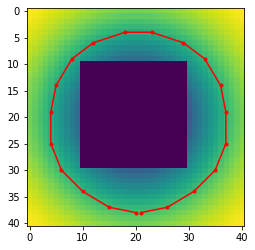

num_updates: 19


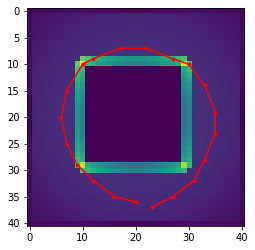

num_updates: 19


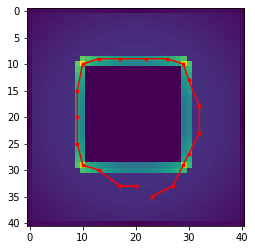

num_updates: 7


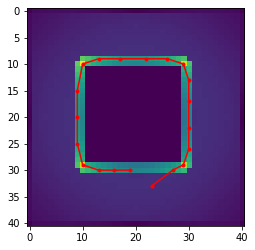

num_updates: 2


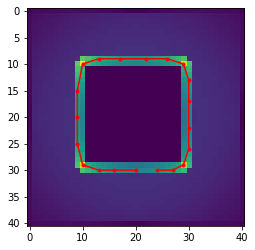

In [ ]:
# load image
input_dict = np.load('data/exercise_4/ueb422.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 7,
    'contour_fraction': 0.1,
    'alpha': 0.,
    'beta': 2.,
    'gamma': 1.,
    'begin_corner_elim': 10,
    'K_threshold': 1
}

# run snake
snake(image, contour, **kwargs)

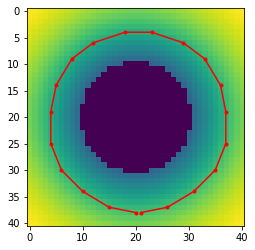

num_updates: 19


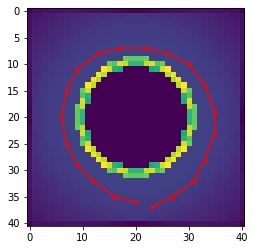

num_updates: 19


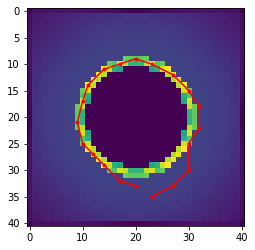

num_updates: 12


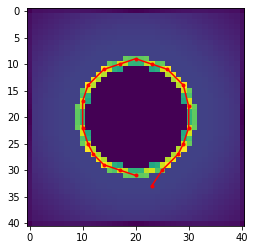

num_updates: 2


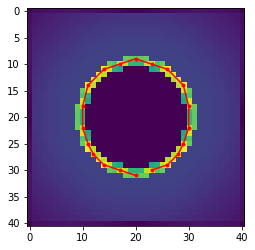

In [ ]:
# load image
input_dict = np.load('data/exercise_4/ueb421.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 7,
    'contour_fraction': 0.1,
    'alpha': 0.,
    'beta': 2.,
    'gamma': 1.,
    'begin_corner_elim': 10,
    'K_threshold': 1
}

# run snake
snake(image, contour, **kwargs)

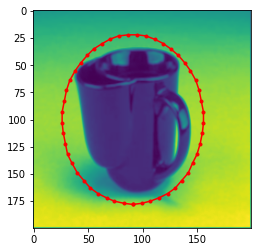

num_updates: 35


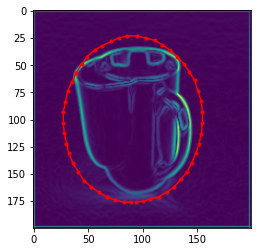

num_updates: 33


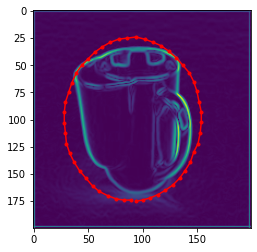

num_updates: 34


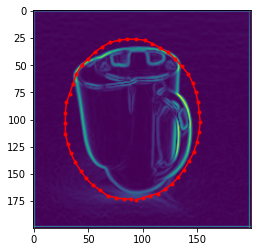

num_updates: 37


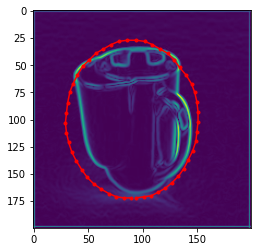

num_updates: 36


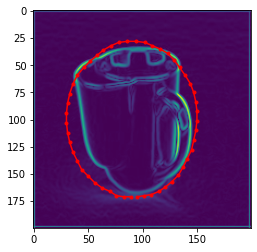

num_updates: 37


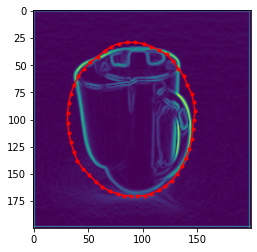

num_updates: 36


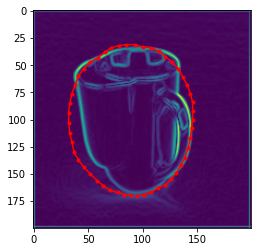

num_updates: 38


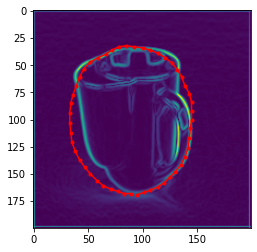

num_updates: 35


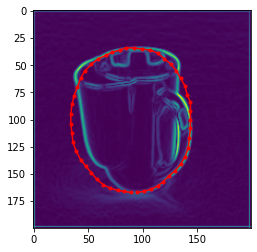

num_updates: 28


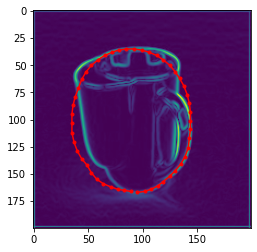

num_updates: 26


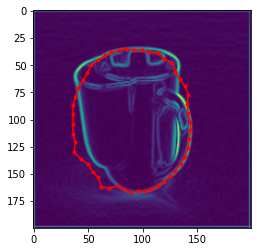

num_updates: 19


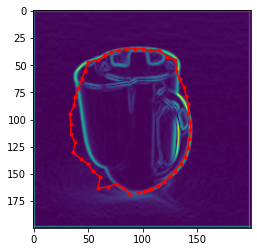

num_updates: 23


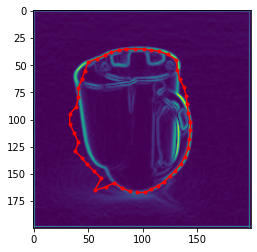

num_updates: 16


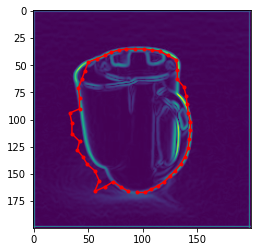

num_updates: 18


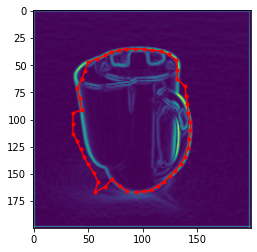

num_updates: 21


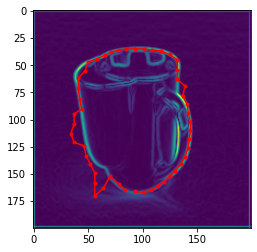

num_updates: 20


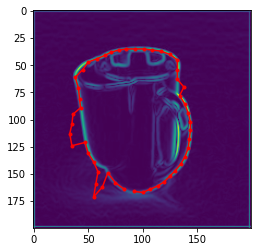

num_updates: 17


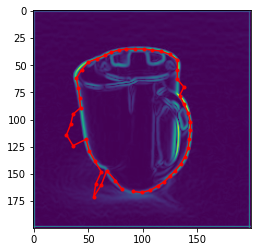

num_updates: 12


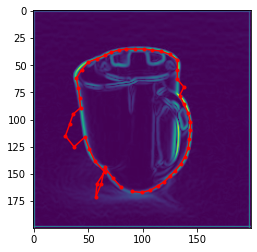

num_updates: 15


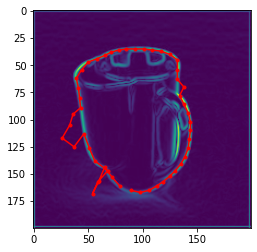

num_updates: 16


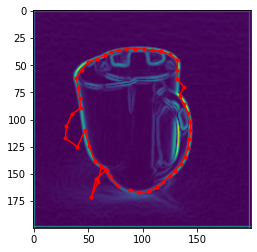

num_updates: 17


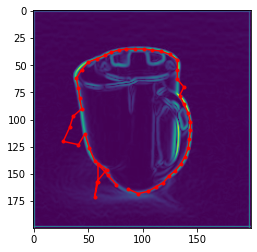

num_updates: 19


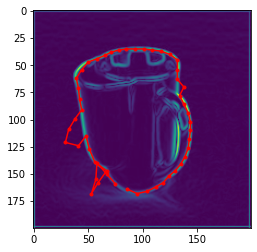

num_updates: 17


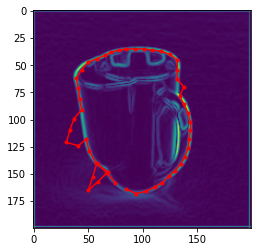

num_updates: 14


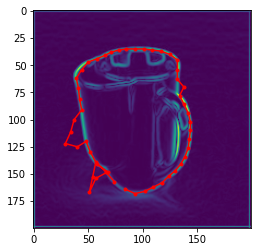

num_updates: 16


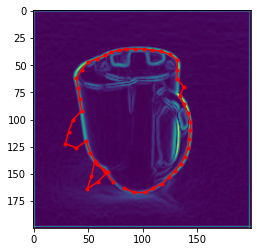

num_updates: 13


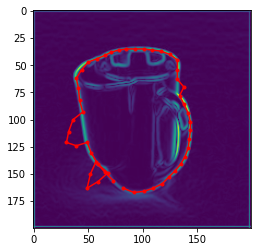

num_updates: 14


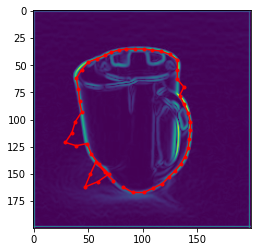

num_updates: 8


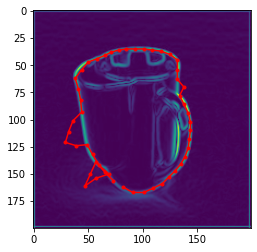

num_updates: 6


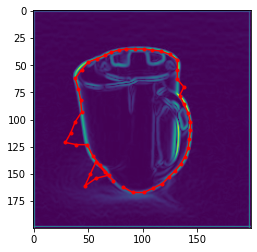

num_updates: 9


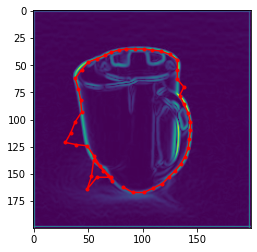

num_updates: 15


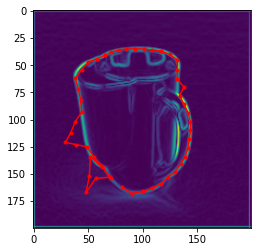

num_updates: 13


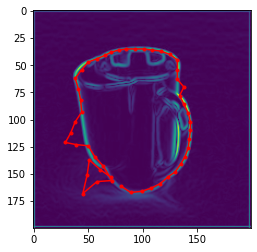

num_updates: 15


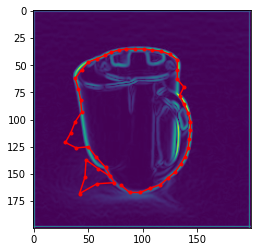

num_updates: 13


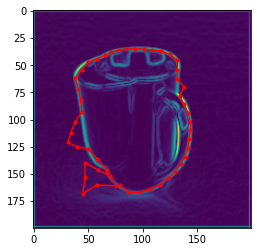

num_updates: 11


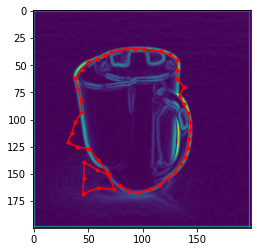

num_updates: 13


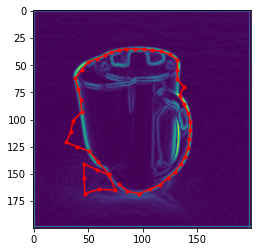

num_updates: 9


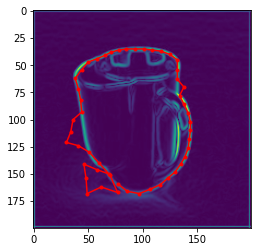

num_updates: 12


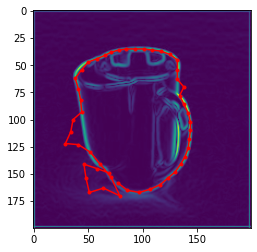

num_updates: 17


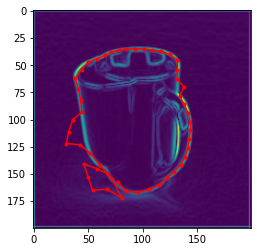

num_updates: 15


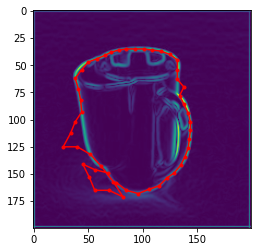

num_updates: 12


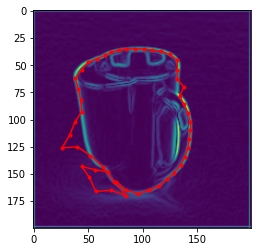

num_updates: 14


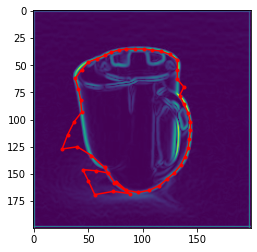

num_updates: 14


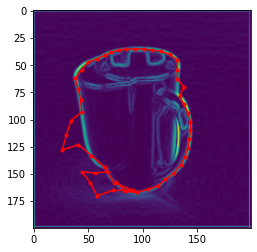

num_updates: 15


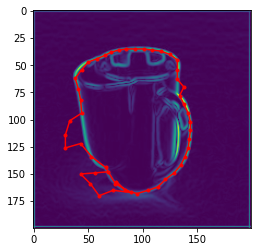

num_updates: 13


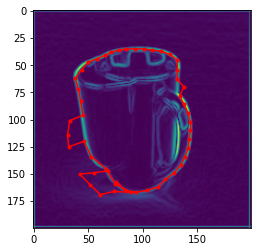

num_updates: 16


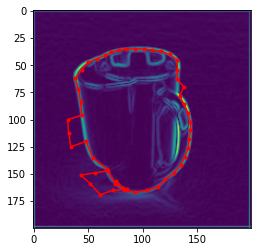

num_updates: 16


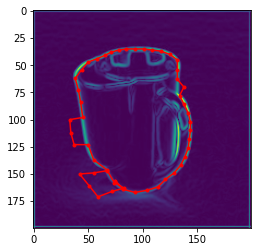

num_updates: 15


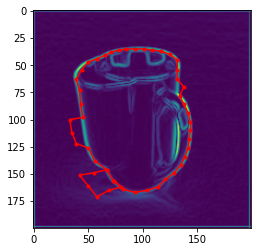

num_updates: 13


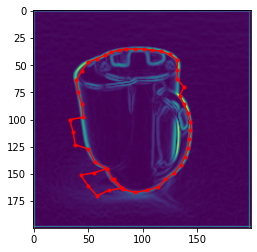

num_updates: 7


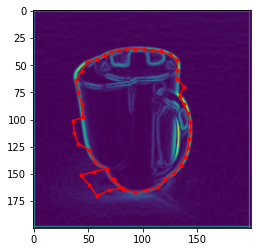

num_updates: 13


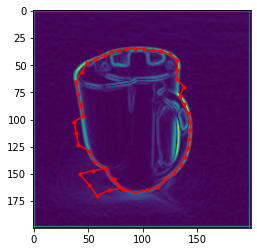

num_updates: 11


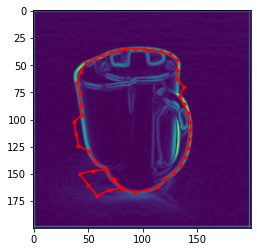

num_updates: 12


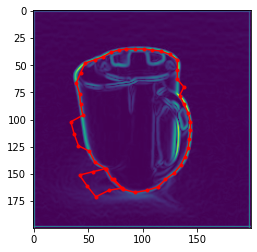

num_updates: 8


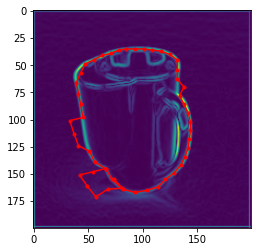

num_updates: 11


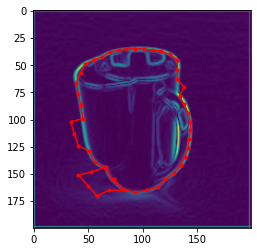

num_updates: 13


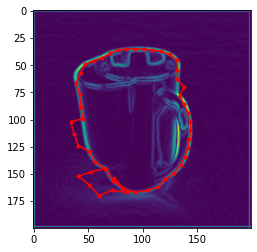

num_updates: 21


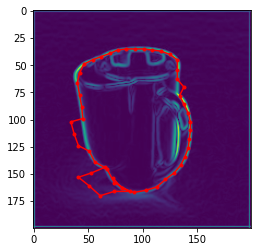

num_updates: 12


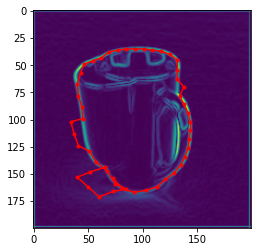

num_updates: 13


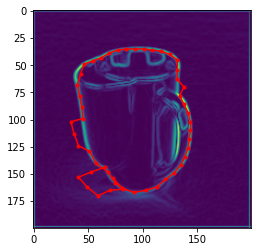

num_updates: 10


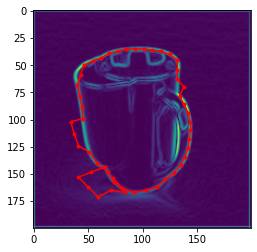

num_updates: 6


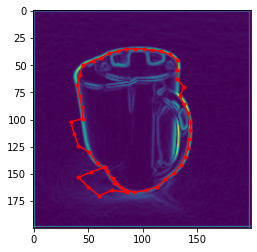

num_updates: 10


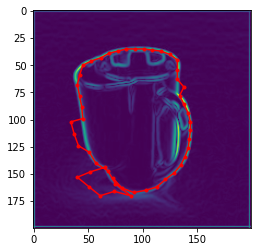

num_updates: 9


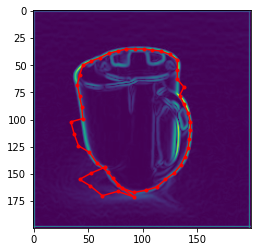

num_updates: 5


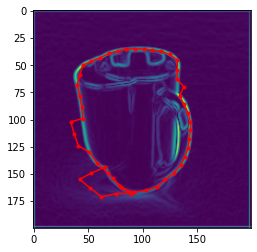

In [ ]:
# load image
input_dict = np.load('data/exercise_4/ueb423.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 7,
    'contour_fraction': 0.1,
    'alpha': 15.,
    'beta': 8.,
    'gamma': 0.5,
    'begin_corner_elim': 10,
    'K_threshold': 1
}
# run snake
snake(image, contour, **kwargs)